In [16]:
# Import necessary libraries
import os
import numpy as np
import cv2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
!pip install xgboost


     ------------------------------------ 124.9/124.9 MB 227.4 kB/s eta 0:00:00


In [11]:
# Dataset directories
data_dir = r'D:\PFE\D2\balanced_dataset'  # Main dataset directory
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
validation_dir = os.path.join(data_dir, "validation")


In [12]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7  # Number of classes in the dataset


In [13]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Background removal using color thresholding
def remove_background_color_thresholding(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])  # Lower bound for green in HSV
    upper_green = np.array([85, 255, 255])  # Upper bound for green in HSV
    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(image, image, mask=mask_inv)
    return result


In [17]:
# Load and preprocess data
def load_data(data_dir, apply_clahe_flag=False, apply_color_thresholding=False):
    original_images, preprocessed_images, labels = [], [], []
    for label, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            
            # Resize and normalize the image
            img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            original_images.append(img_resized / 255.0)
            
            # Preprocess the image
            preprocessed_img = img_resized.copy()
            if apply_color_thresholding:
                preprocessed_img = remove_background_color_thresholding(preprocessed_img)
            if apply_clahe_flag:
                preprocessed_img = apply_clahe(preprocessed_img)
            preprocessed_images.append(preprocessed_img / 255.0)
            
            labels.append(label)
    return np.array(original_images), np.array(preprocessed_images), np.array(labels)

# Load train, test, and validation data
X_train_original, X_train_preprocessed, y_train = load_data(train_dir, apply_clahe_flag=True, apply_color_thresholding=True)
X_test_original, X_test_preprocessed, y_test = load_data(test_dir, apply_color_thresholding=True)
X_val_original, X_val_preprocessed, y_val = load_data(validation_dir, apply_color_thresholding=True)


In [18]:
# One-hot encode the labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)

# Define the model (using DenseNet201 as in the original code)
def create_model(input_shape, num_classes):
    base_model = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model




In [19]:
# Create and train the model
model = create_model((IMG_SIZE[0], IMG_SIZE[1], 3), NUM_CLASSES)




74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 39s 1us/step


In [21]:
# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=35,
    batch_size=BATCH_SIZE
)

Epoch 1/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.1502 - loss: 2.3500 - val_accuracy: 0.2222 - val_loss: 2.1232
Epoch 2/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.2337 - loss: 2.0696 - val_accuracy: 0.2222 - val_loss: 1.9904
Epoch 3/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.3293 - loss: 1.8836 - val_accuracy: 0.3333 - val_loss: 1.9094
Epoch 4/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.3793 - loss: 1.6149 - val_accuracy: 0.3333 - val_loss: 1.8018
Epoch 5/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.4500 - loss: 1.4465 - val_accuracy: 0.3651 - val_loss: 1.7452
Epoch 6/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.5633 - loss: 1.3145 - val_accuracy: 0.3810 - val_loss: 1.7087
Epoch 7/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.6031 - loss: 1.1564 - val_accuracy: 0.3968 - val_loss: 1.6716
Epoch 8/35
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.5982 - loss: 1.0962 - val_accuracy: 0.4286 - val_loss: 1.6313
Epoch 9/

In [22]:
# Continue training the model with additional epochs
additional_epochs = 10  # Define how many additional epochs you want

history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=additional_epochs + 35,  # Total epochs = original 35 + additional
    batch_size=BATCH_SIZE,
    initial_epoch=35  # Start from epoch 35
)

Epoch 36/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.9017 - loss: 0.3901 - val_accuracy: 0.4921 - val_loss: 1.5078
Epoch 37/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.8858 - loss: 0.3964 - val_accuracy: 0.4921 - val_loss: 1.5202
Epoch 38/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8630 - loss: 0.4061 - val_accuracy: 0.4921 - val_loss: 1.5189
Epoch 39/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8724 - loss: 0.4221 - val_accuracy: 0.5079 - val_loss: 1.5080
Epoch 40/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9176 - loss: 0.3416 - val_accuracy: 0.5079 - val_loss: 1.5047
Epoch 41/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8962 - loss: 0.3484 - val_accuracy: 0.5079 - val_loss: 1.5363
Epoch 42/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8900 - loss: 0.4225 - val_accuracy: 0.4762 - val_loss: 1.5594
Epoch 43/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.8847 - loss: 0.3973 - val_accuracy: 0.5079 - val_loss: 1.5402


In [23]:
# Continue training the model with additional epochs
additional_epochs = 10  # Define how many additional epochs you want

history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=additional_epochs + 45,  # Total epochs = original 35 + additional
    batch_size=BATCH_SIZE,
    initial_epoch=45  # Start from epoch 35
)

Epoch 46/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9196 - loss: 0.3436 - val_accuracy: 0.5079 - val_loss: 1.5478
Epoch 47/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.9125 - loss: 0.3653 - val_accuracy: 0.5079 - val_loss: 1.5463
Epoch 48/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.8892 - loss: 0.3343 - val_accuracy: 0.5238 - val_loss: 1.5586
Epoch 49/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9072 - loss: 0.3726 - val_accuracy: 0.5238 - val_loss: 1.5762
Epoch 50/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9123 - loss: 0.3017 - val_accuracy: 0.4762 - val_loss: 1.5551
Epoch 51/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.8870 - loss: 0.3427 - val_accuracy: 0.4921 - val_loss: 1.5782
Epoch 52/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9179 - loss: 0.3051 - val_accuracy: 0.4921 - val_loss: 1.5950
Epoch 53/55
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.8954 - loss: 0.3366 - val_accuracy: 0.5079 - val_loss: 1.5858


In [24]:
# Continue training the model with additional epochs
additional_epochs = 10  # Define how many additional epochs you want

history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=additional_epochs + 55,  # Total epochs = original 35 + additional
    batch_size=BATCH_SIZE,
    initial_epoch=55  # Start from epoch 35
)

Epoch 56/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9241 - loss: 0.3006 - val_accuracy: 0.4921 - val_loss: 1.5717
Epoch 57/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.9308 - loss: 0.2687 - val_accuracy: 0.5079 - val_loss: 1.5873
Epoch 58/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.9157 - loss: 0.3134 - val_accuracy: 0.5238 - val_loss: 1.5609
Epoch 59/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8987 - loss: 0.3346 - val_accuracy: 0.4921 - val_loss: 1.6457
Epoch 60/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9137 - loss: 0.3298 - val_accuracy: 0.5079 - val_loss: 1.6000
Epoch 61/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9325 - loss: 0.3094 - val_accuracy: 0.5238 - val_loss: 1.5812
Epoch 62/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8862 - loss: 0.3281 - val_accuracy: 0.4921 - val_loss: 1.6285
Epoch 63/65
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9462 - loss: 0.2522 - val_accuracy: 0.4762 - val_loss: 1.6642


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7047 - loss: 0.8142
Test Accuracy: 0.65


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       0.73      0.89      0.80         9
           2       0.44      0.44      0.44         9
           3       0.88      0.78      0.82         9
           4       0.60      0.33      0.43         9
           5       0.62      0.56      0.59         9
           6       0.71      0.56      0.62         9

    accuracy                           0.65        63
   macro avg       0.66      0.65      0.64        63
weighted avg       0.66      0.65      0.64        63



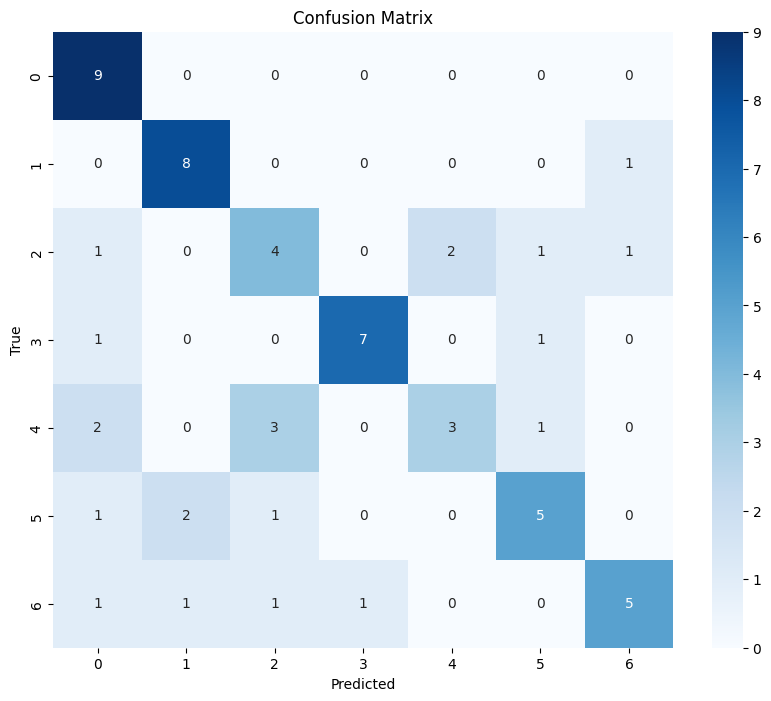

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report and confusion matrix
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()